# Active learning in logistic regression
## Data example
We will work on functional magnetic resonance imaging (fMRI) data in the following exercise. The data comes from a finger-tapping experiment experiment conducted at the Danish Research Centre for Magnetic Resonance at Hvidovre Hospital. The experiment consists of 20 seconds blocks of sequential finger tapping with left or right hand separated by 9.88 seconds of rest between blocks. And contains data recorded on 29 healthy participants on a 3T Siemens Magnetom Trio MR scanner using a gradient echo planar imaging sequence with a repetition rate (inverse sampling rate) of 2.49 seconds.

In fMRI data the socalled BOLD signal is a delayed hemodynamic signal in response to brain activation. In order to produce an estimate of the expected signal change due to finger tapping for each block we here assume a linear time invariant canonical shape of the hemodynamic response function and estimate the signal amplitude in each voxel using a multiple linear regression model. The result is that the 3D dimensional array $\boldsymbol{X}$ contains individual subjects that did the task in the first dimension, samples (that is the 20 seconds activation blocks) as the second dimension, and voxels (3D brain scan unfolded as a vector) as the third dimension.

Additional preprocessing steps include normalization to a standard brain template space (MNI space) and spatial smoothing by 8mm full-width at half-maximum isotropic Gaussian kernel but this is not important for the exercise.

The labels (left/right fingertapping) are provided in the array $\boldsymbol{y}$.
We will simply concatenate across subjects in the following therefore producing a matrix $\boldsymbol{X}$ and a vector $\boldsymbol{y}$.

The idea is to do socalled brain decoding (or what might be referred to as mind reading in the more popular literature) where we in this simple setting attempt to determine if subjects finger tapped with either left or right hand in each block.
You likely have to be a little patient when downloading the data, as the file is around 400MB. It is also availible on DTU Inside just in case.


In [1]:
#Preliminaries
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import urllib.request
import os, sys
url = 'http://www.brain-fmri.com/AL/fmri_lr_all.npz'
datafile = 'fmri_lr_all.npz'

from tqdm import tqdm

if not os.path.exists(datafile): #only download if not already on path
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
    with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url,datafile, reporthook=t.update_to) #400 MB datafile, will take some time
data=np.load(datafile,allow_pickle=True)
X=data['X']
y=data['y']

/home/simnibs/miniconda3/envs/02463/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



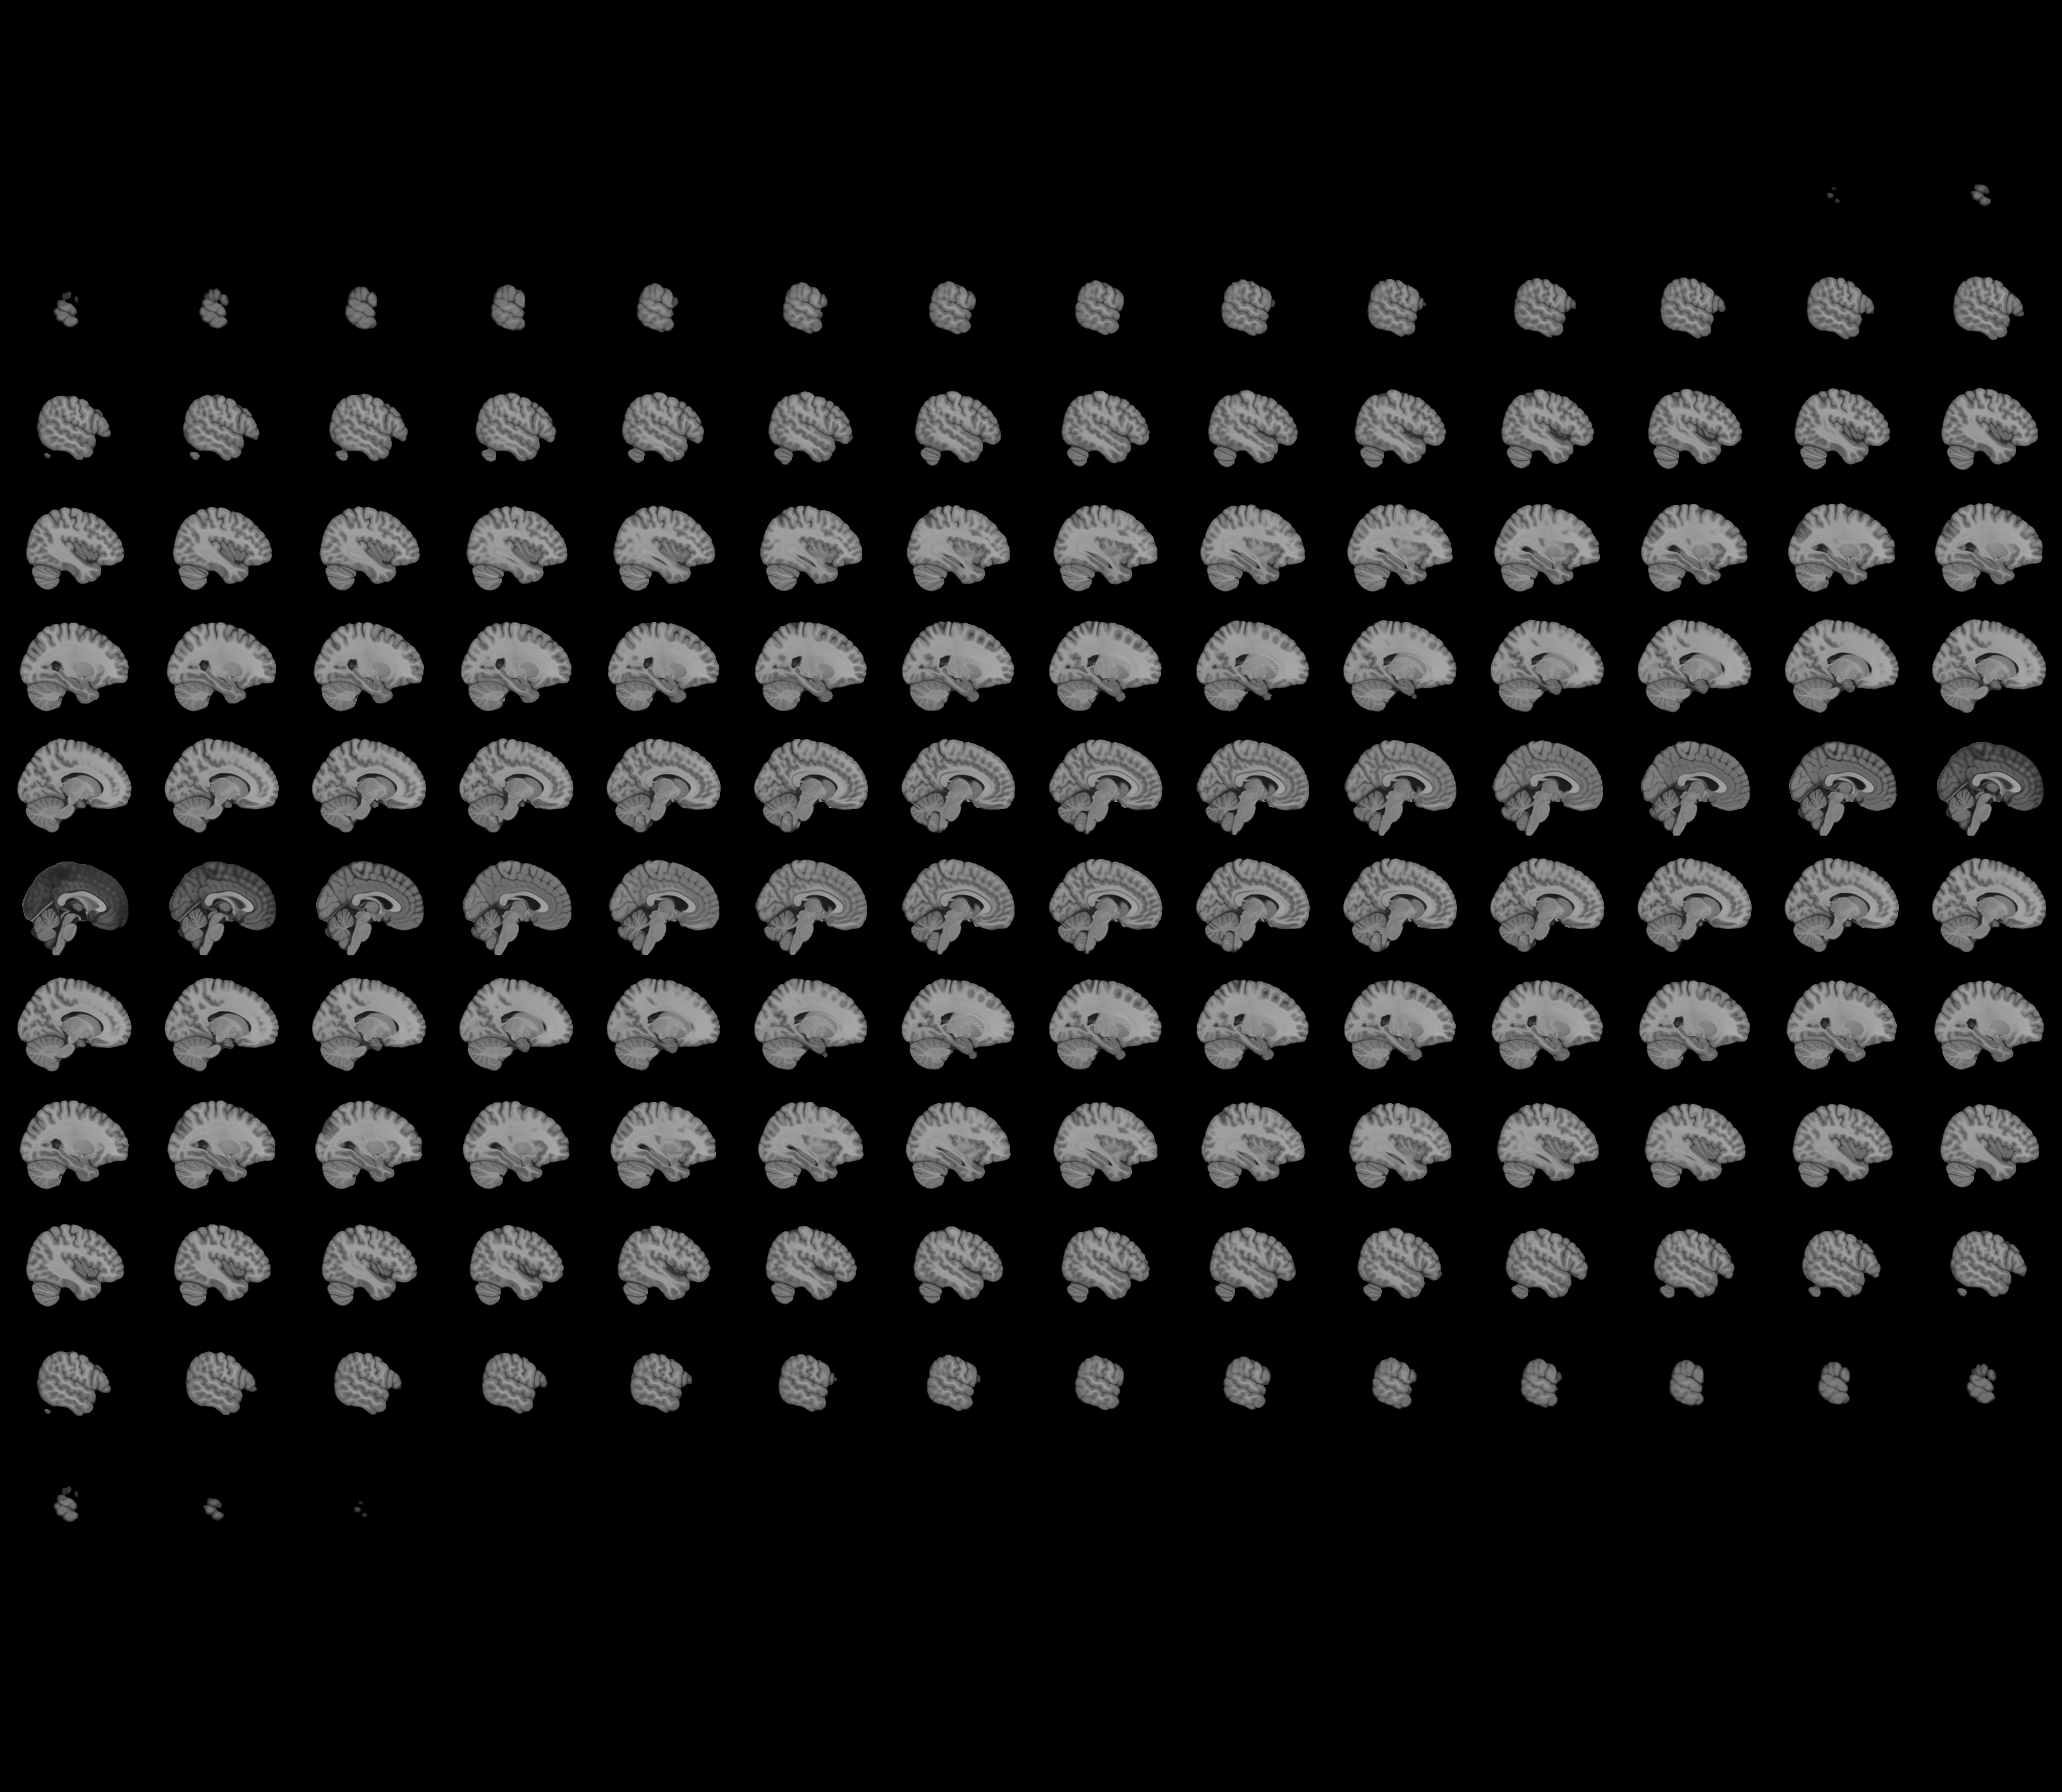
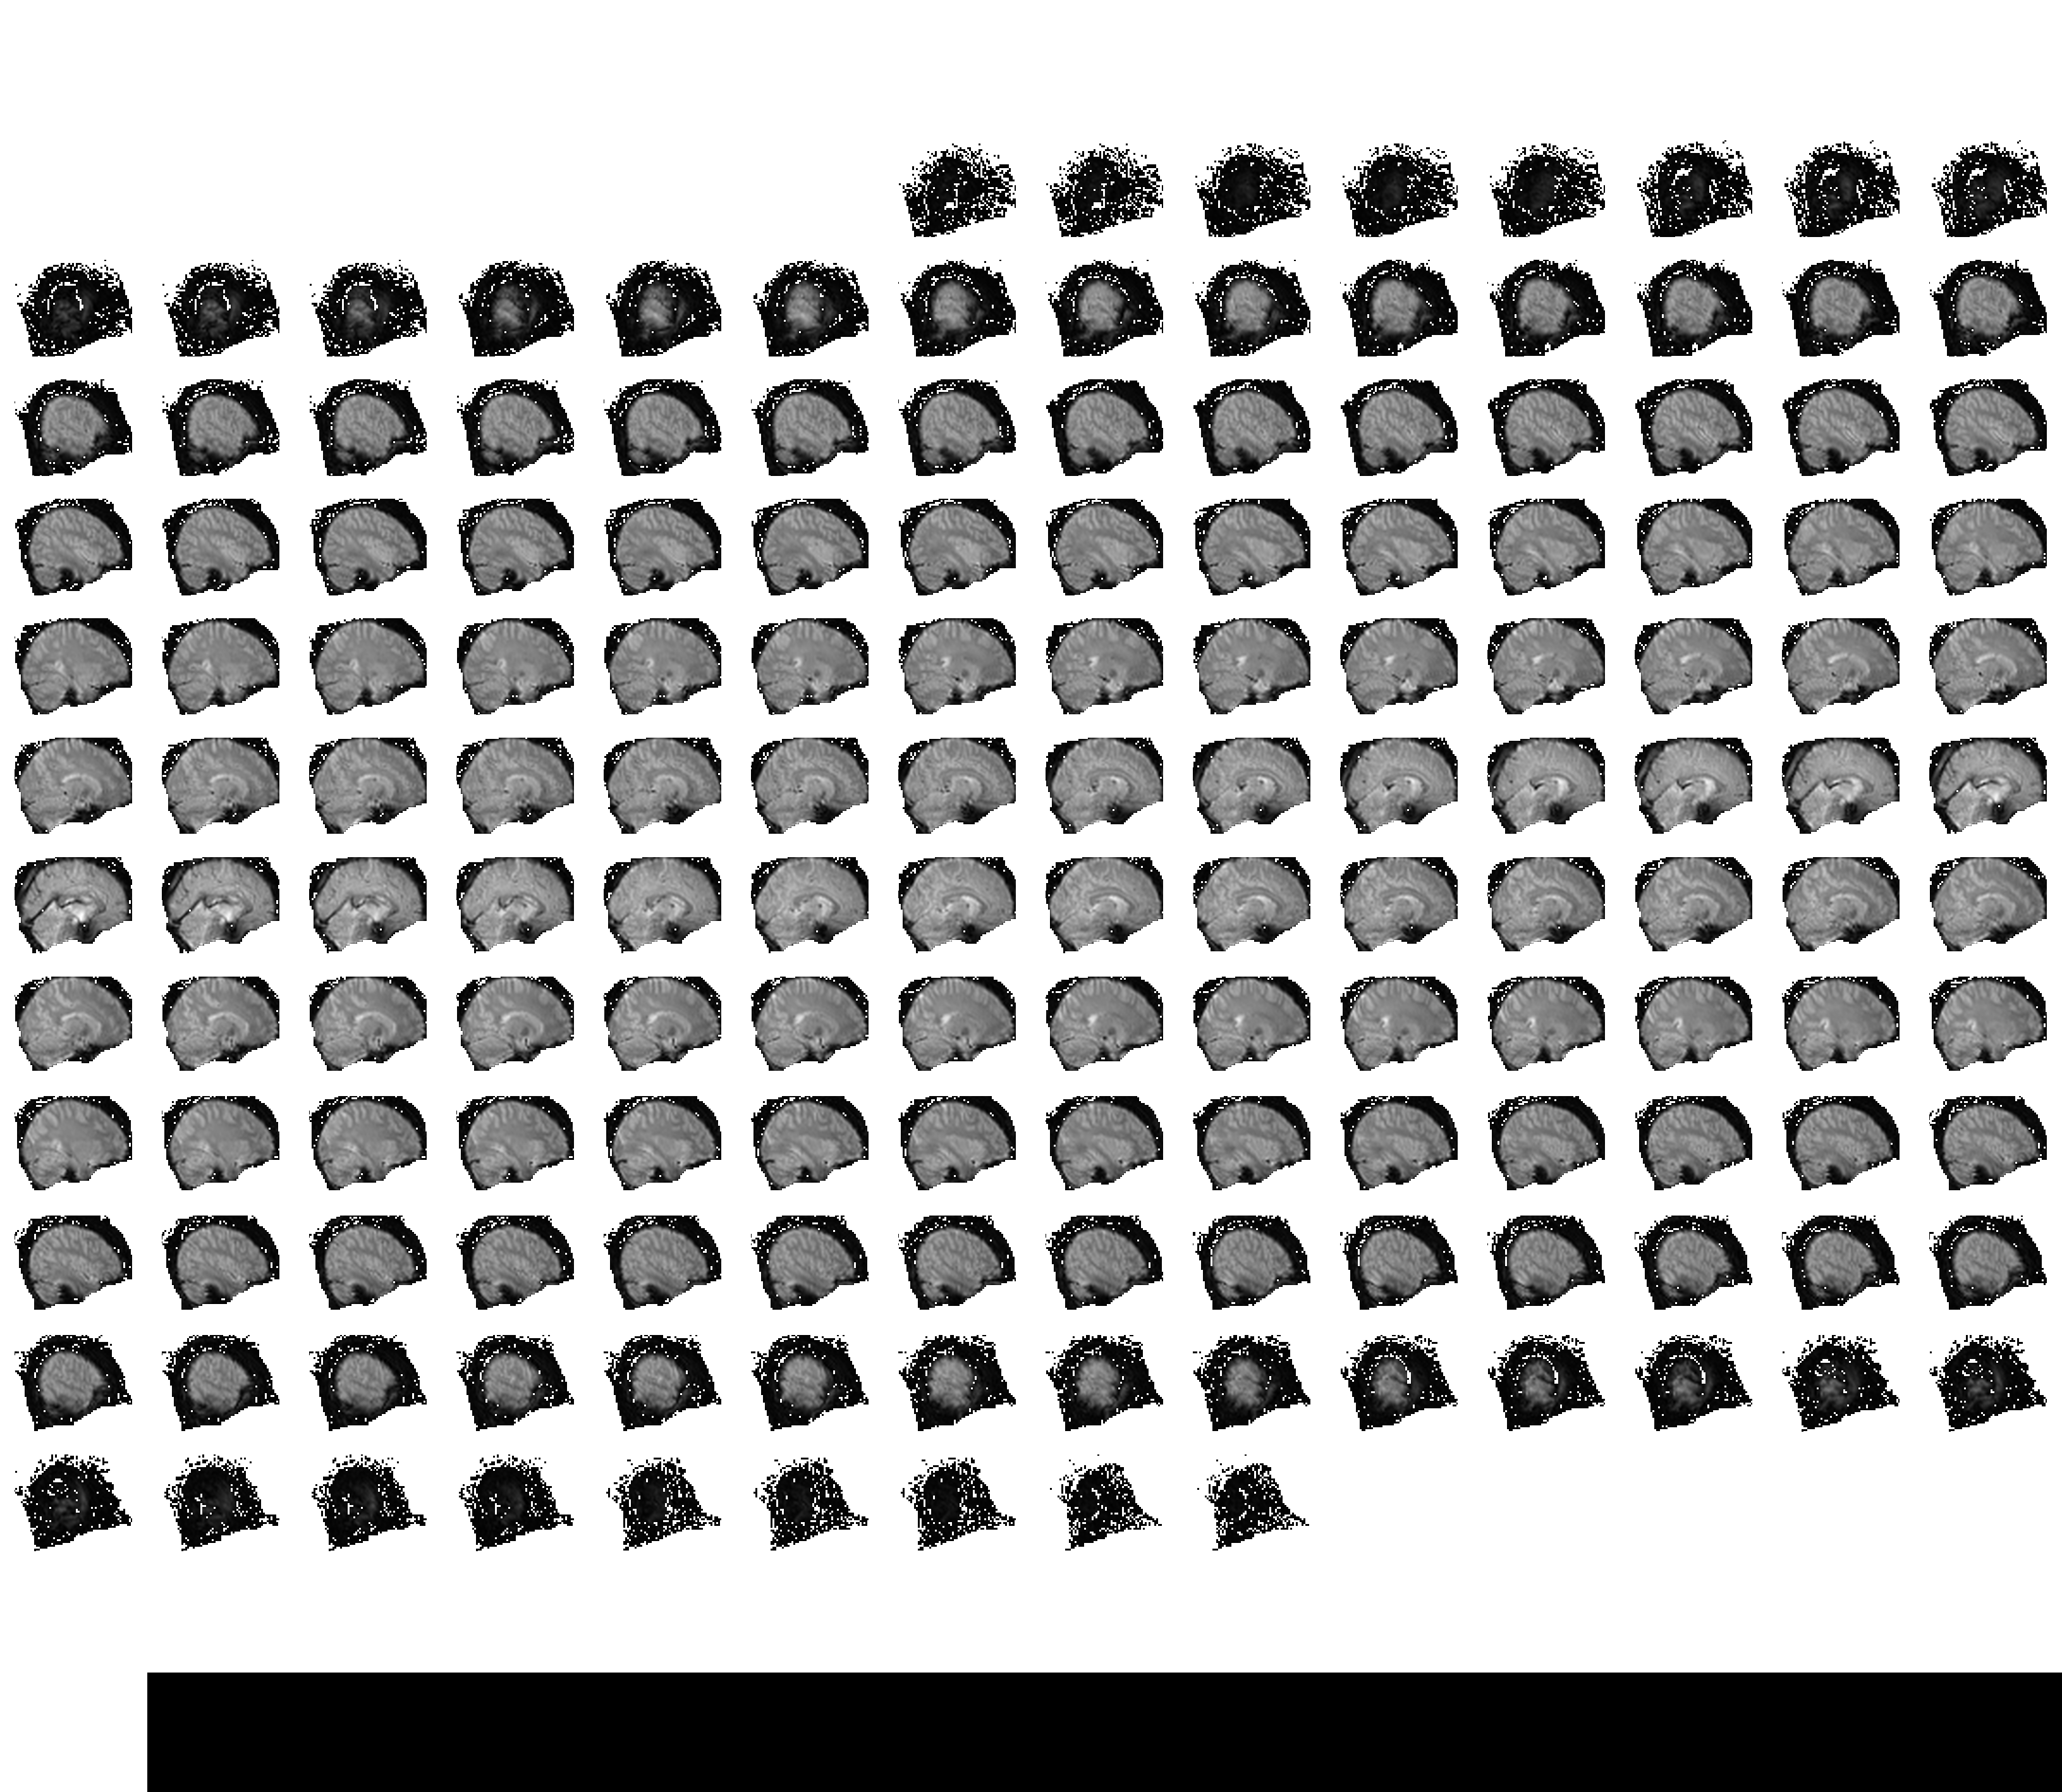

In [2]:
#Visualize mean image - optional but will enable visualization of weight maps
#nilearn has easy to use visualizers for 3D MRI images
#!{sys.executable} -m pip install nilearn
#install nilearn via pip - perhaps use conda:
#"conda -c conda-forge nilearn" if you are using an Anaconda python install instead

import nilearn.plotting
import nibabel as nib
avgimg=data['avgimg']
#affine transformation matrix to MNI space:
affine=np.array([[  3.,    0.,    0.,   -78.],
       [   0.,    3.,    0., -112.],
       [   0.,    0.,    3.,  -70.],
       [   0.,    0.,    0.,    1.]])
#non-interactive plotting:
#nilearn.plotting.plot_epi(nib.Nifti1Image(avgimg,affine=affine),cmap='gray');
#interactive plotting:
nilearn.plotting.view_img(nib.Nifti1Image(avgimg*(avgimg>0),affine=affine),symmetric_cmap=False,threshold=10,cmap='gray')

The problem is quite high dimensional as each brain volume consists of 173.628 voxels of 2mm isotropic resolution. In the following we will initially consider a simple logistic regression model for this purpose, however most of this would immediately generalize to other models such as the SVC and linear discriminant analysis. The idea is to consider pool based sampling as an active learning scenario.
We want the model to generalize across subjects and therefore reserve a test set using the last 15 participants, and consider the remaining samples from 14 participants as part of an unlabeled pool.

In [3]:
#in order to reduce the feature space a bit we do a simple threshold of the mean image (80% of global mean)
#this is not really needed but make the computations a bit faster
mask=avgimg>(0.8*avgimg.mean())
#divide up into training pool for pool based active learning

Xtest=np.concatenate(X[14:])[:,mask.ravel()]
ytest=np.concatenate(y[14:])
Xpool=np.concatenate(X[:14])[:,mask.ravel()]
ypool=np.concatenate(y[:14])
Xtest.shape

(300, 69655)

We then define a Logistic regression model using sklearn and investigate how performance change when gradually increasing the training set randomly from 10 to 58 samples (here in steps of 2 such that this does not take too long).

<span style="color:green;font-style:italic">
1. Define logistic regression model using sklearn, the $C=1$ regularization parameter should not be too important as long as there is a bit of penalty (at least $C=1$ seems to work ok)
2. Complete the training loop and calculate the accuracy each time samples are added
</span>

In [4]:
import sklearn.linear_model as lin
lr = lin.LogisticRegression(penalty='l2',C=1.)

np.random.seed(42) # random seed to ensure same results but feel free to change
addn=2 #samples to add each time
#randomize order of pool to avoid sampling the same subject sequentially
order=np.random.permutation(range(len(Xpool)))
Xpool.shape

(280, 69655)

In [5]:
#samples in the pool
poolidx=np.arange(len(Xpool),dtype=np.int64)
ninit = 10 #initial samples
#initial training set
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
#remove data from pool
poolidx=np.setdiff1d(poolidx,trainset)

model=lr
testacc=[]
for i in range(25):
    #Fit model
    model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0),np.take(ypool,order[:ninit+i*addn],axis=0))
    #predict on test set
    ye=model.predict(Xtest)
    #calculate and accuracy and add to list
    testacc.append((ninit+i*addn,sklearn.metrics.accuracy_score(ytest,ye)))
    print('Model: LR, %i random samples'%(ninit+i*addn))

Model: LR, 10 random samples
Model: LR, 12 random samples
Model: LR, 14 random samples
Model: LR, 16 random samples
Model: LR, 18 random samples
Model: LR, 20 random samples
Model: LR, 22 random samples
Model: LR, 24 random samples
Model: LR, 26 random samples
Model: LR, 28 random samples
Model: LR, 30 random samples
Model: LR, 32 random samples
Model: LR, 34 random samples
Model: LR, 36 random samples
Model: LR, 38 random samples
Model: LR, 40 random samples
Model: LR, 42 random samples
Model: LR, 44 random samples
Model: LR, 46 random samples
Model: LR, 48 random samples
Model: LR, 50 random samples
Model: LR, 52 random samples
Model: LR, 54 random samples
Model: LR, 56 random samples
Model: LR, 58 random samples


/home/simnibs/miniconda3/envs/02463/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



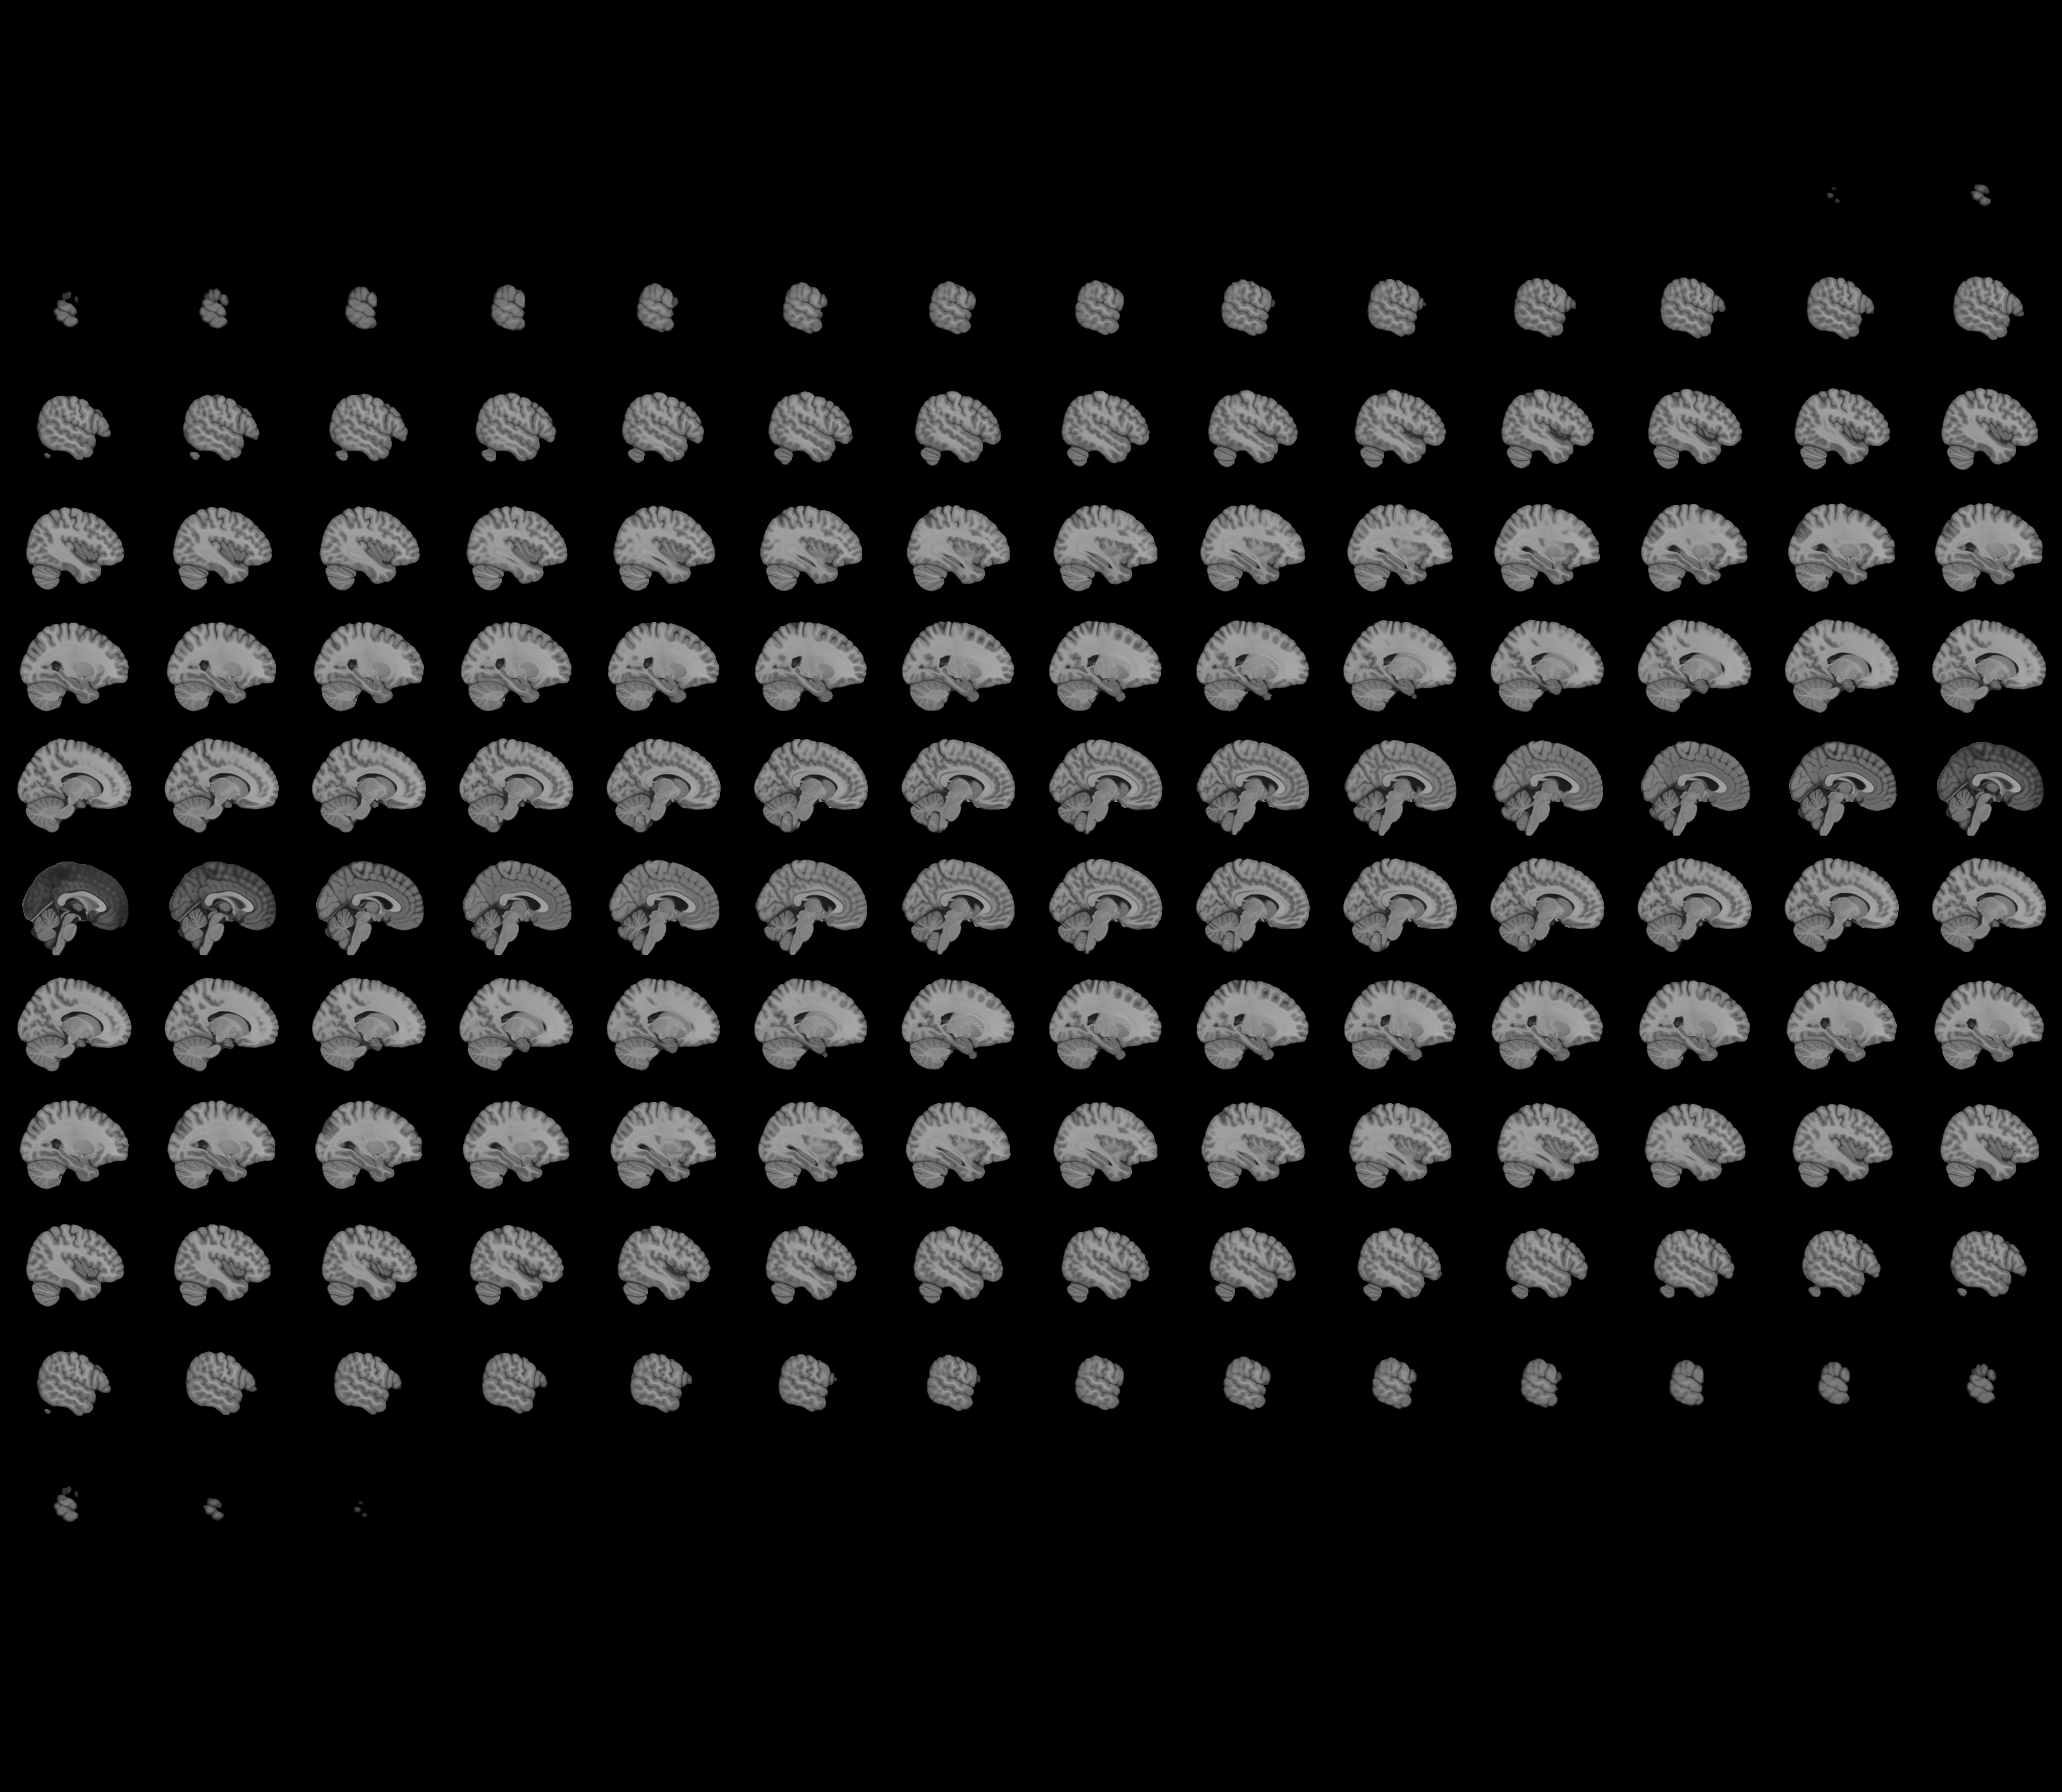
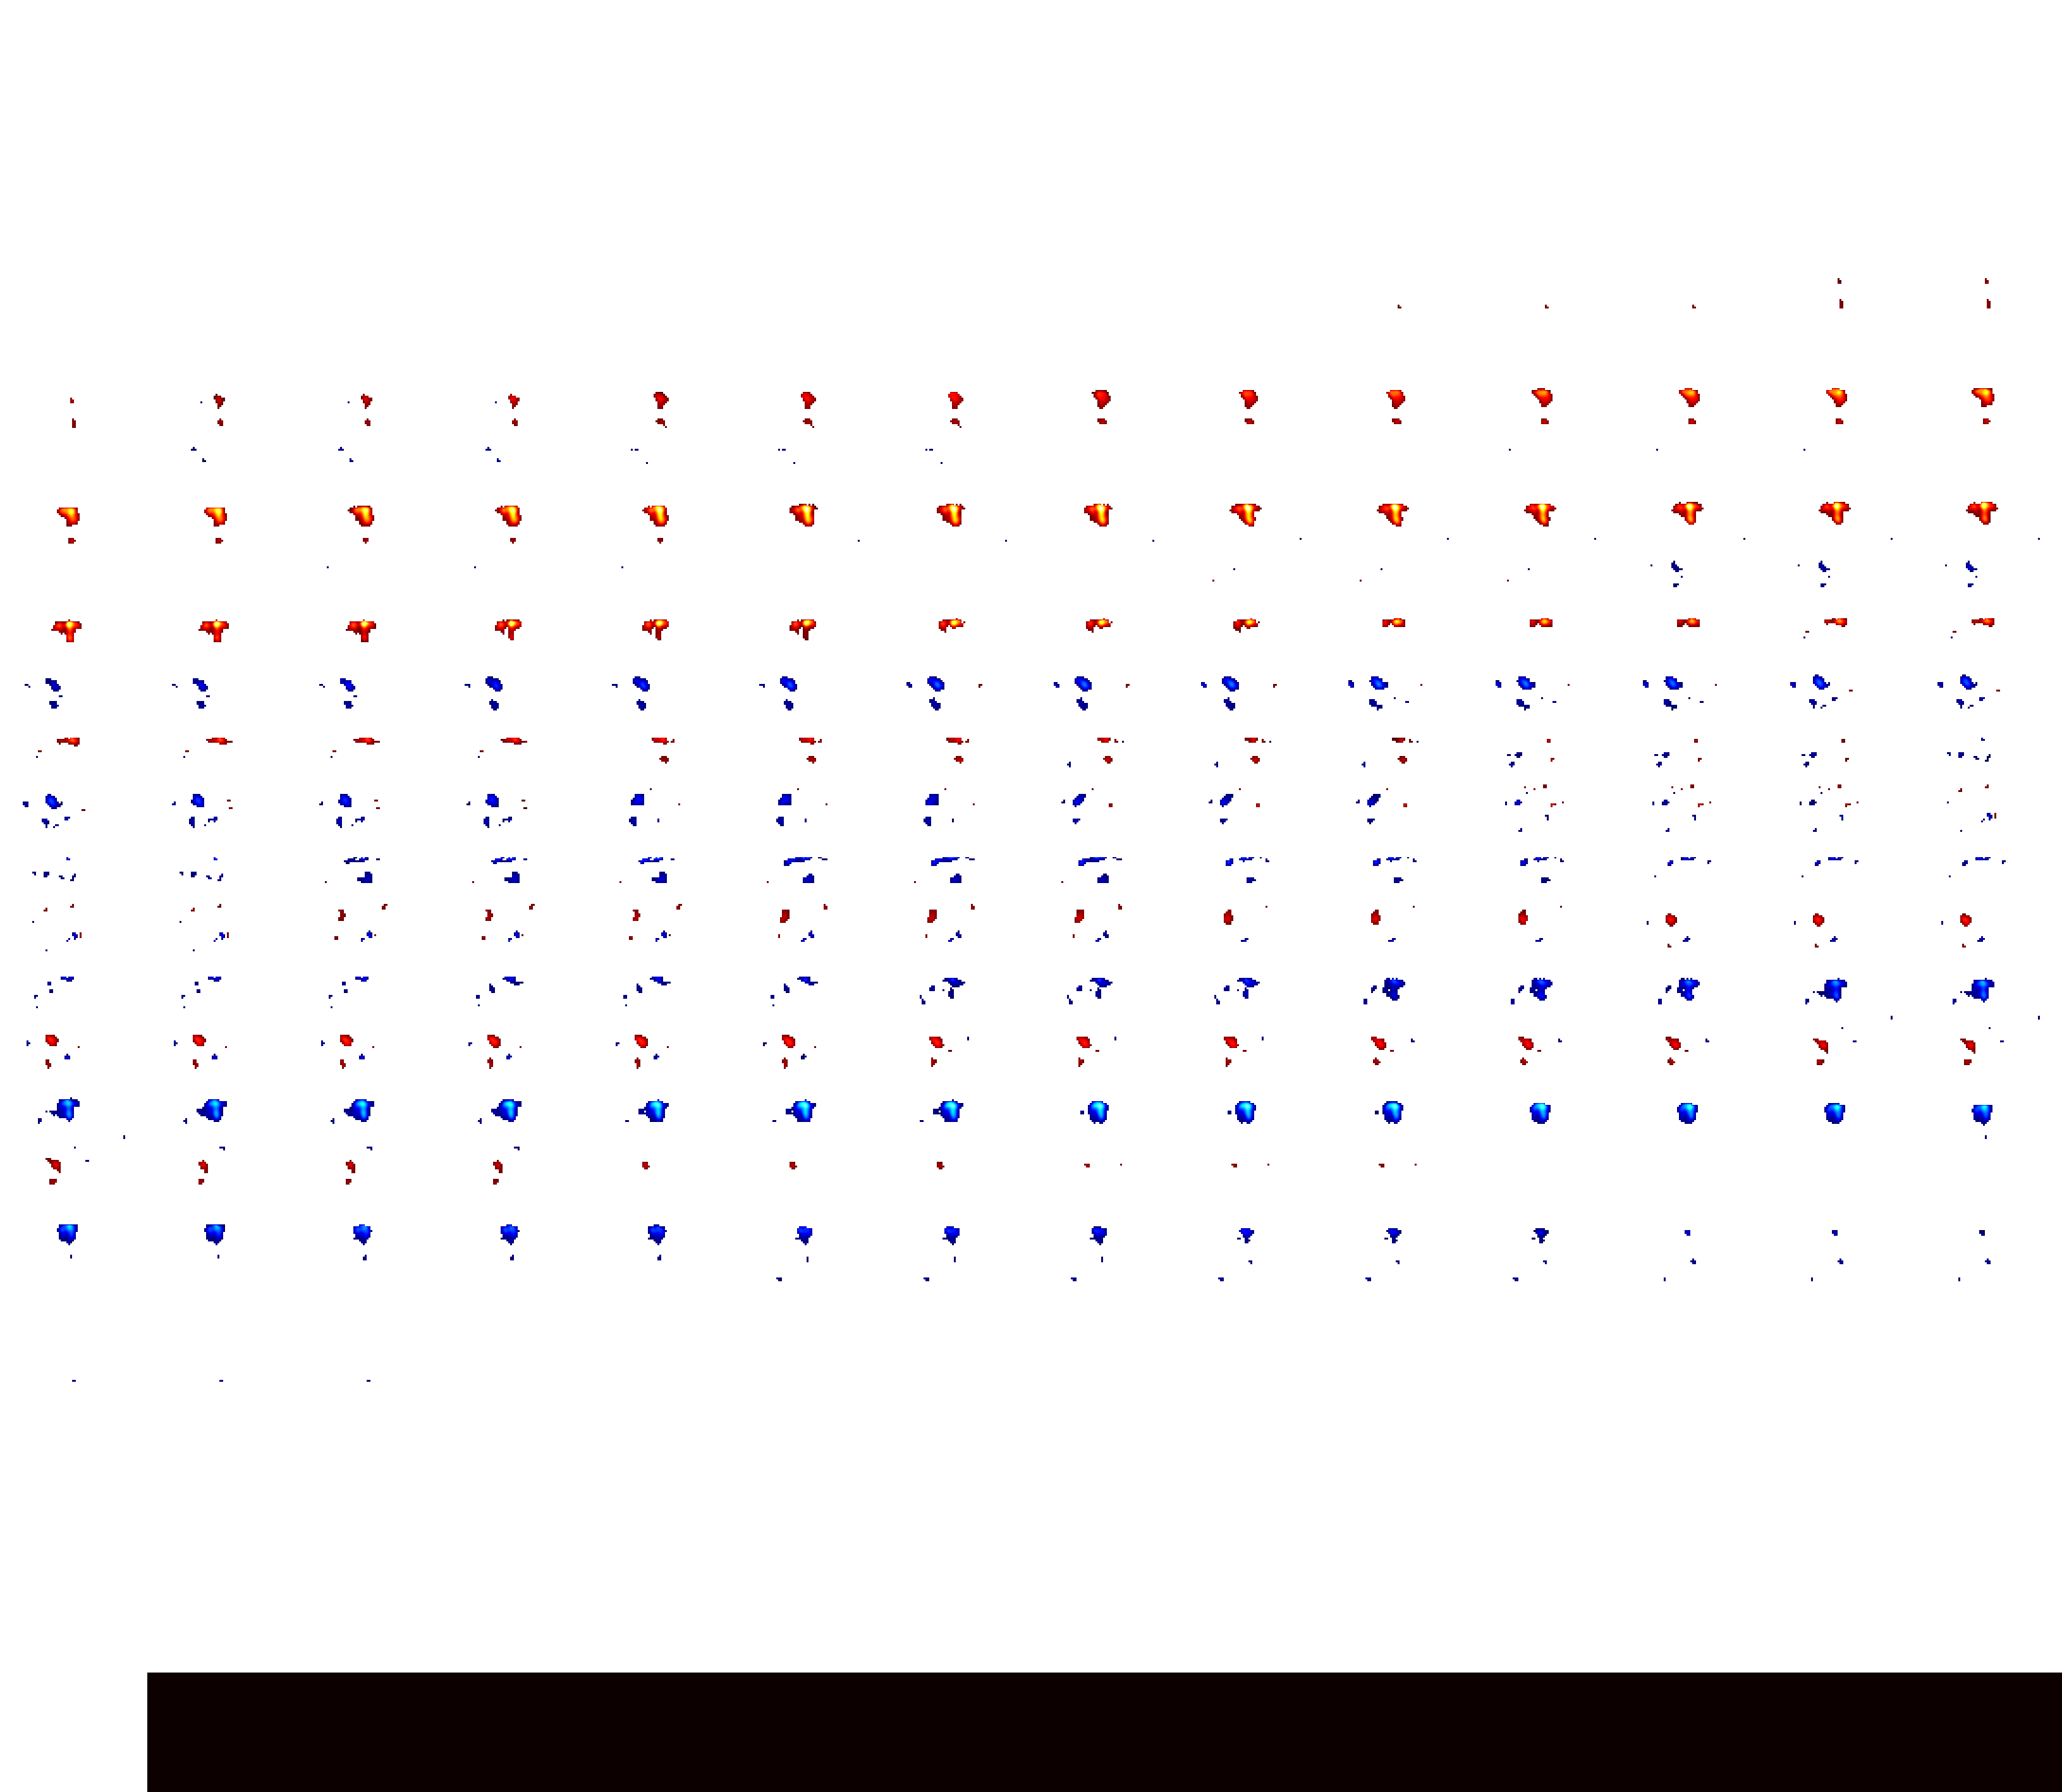

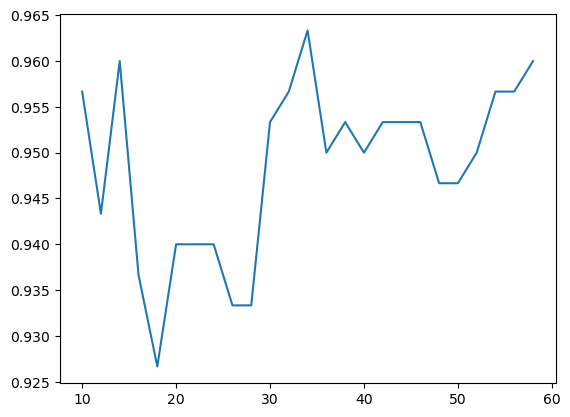

In [6]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));

#if you want to visualize the weightmap of the model you can do like stated below
w=np.zeros(avgimg.shape)
w[mask]=model.coef_[0]
#Plotting static version:
#nilearn.plotting.plot_stat_map(nib.Nifti1Image(w,affine=affine),bg_img=nib.Nifti1Image(avgimg,affine=affine),
#                               threshold=np.quantile(model.coef_[0],.99));

nilearn.plotting.view_img(nib.Nifti1Image(w,affine=affine),
                          threshold=np.quantile(w,.99),)

# <font color=blue> Optional question for the brain interested: which label corresponds to finger tapping with the right hand?<br>

Take a look at: https://www.getbodysmart.com/motor-system if you want a very basic intro to the motor system.

Or https://www.coursera.org/lecture/medical-neuroscience/overview-of-the-motor-system-LwlWB if you want a much more substantial one.
    <br>
    <br>

<span style="color:green;font-style:italic">
    Answer:
    The high class (label=2) corresponds to right hand finger-tapping while the low class (label=1) is left hand. This can be seen because the weight map indicates that increased BOLD signal in the left cortical primary motor cortex is associated with the high class. The representation of the left hand is in a cortical area in right hemisphere as the motor fibres cross near the medulla. Noteably, if you take a look at the cerebellum the pathways are not crossed and the relationsship is reversed (see below).  
    </span>

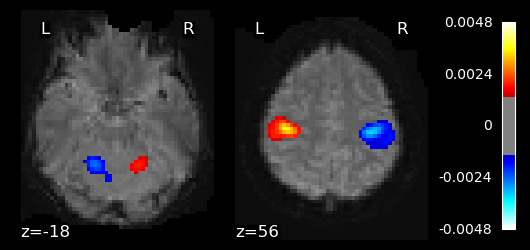

In [7]:
nilearn.plotting.plot_stat_map(nib.Nifti1Image(w,affine=affine),bg_img=nib.Nifti1Image(avgimg,affine=affine),
                               threshold=np.quantile(model.coef_[0],.99),display_mode='z',cut_coords=(-18,56));

# Uncertainty sampling
In the following grow the training set by uncertainty sampling from the pool. For the logistic regression model you can get label probabilities using the .predict_proba method and manually calculate your preferred uncertainty metric (least confident, minimum margin, entropy).

<font color=blue> 1. Is active learning outperforming random sampling in this setting?<br>
     <span style="color:green;font-style:italic">
    Yes, the performance of active learning appear to be consistently outperforming random sampling, note that the classification task is rather easy here as the performance is already high given only few samples.
         </span>
    <br>
<font color=blue> 2. Will it make a difference which one of the three metrics you use here?<br>
     <span style="color:green;font-style:italic">
         No, as this is binary classification the three metrics (least confident, margin and entropy) will lead to the same sample being acquired (the one nearest p=0.5) the two first are obviously equivalent, and as log is a monitonic function, we can explicitly see this by equating the derivative of the entropy to zero, as shown below using sympy.
         </span>
<br><font color=blue>3. Here we still add two samples at the time is this a good idea - why/why not?<br>
 <span style="color:green;font-style:italic">
     Likely this is not a very good idea the risk is that the two points we are adding are quite similar, and hence this type of batch adding of uncertain samples can be a bad idea. Optimimally, such approach should take into account the distance/correlation between samples in the pool or evaluate expectations for all combinations - unfortunately this would be prohibitively expensive to do naively in most settings.
    </span>
<br>Code to write:
<br>Loop in which the current model is fit, accuracy is calculated. Then most uncertain samples are determined and added to the training set and removed from the pool.  
   

In [8]:
# solution::start
import sympy
sympy.init_printing()
px=sympy.Symbol('p(x)')
E=px*sympy.log(px)+(1-px)*sympy.log(1-px)
print('E=%s'%E)
dE=sympy.diff(E,px)
print('dE/dp(x)=%s'%dE)
px_opt=sympy.solve(dE,px)
print(r'p_{opt}(x)=%s'%px_opt)
# solution::end

E=p(x)*log(p(x)) + (1 - p(x))*log(1 - p(x))
dE/dp(x)=log(p(x)) - log(1 - p(x))
p_{opt}(x)=[1/2]


In [9]:
#reset training set and pool
testacc_al=[]
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)
for i in range(25):
    #fit model
    model.fit(Xtrain,ytrain)
    #predict on test set
    ye=model.predict(Xtest)
    #calculate accuracy and add to list
    testacc_al.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))
    #get label probabilities on unlabelled pool
    ypool_p = model.predict_proba(Xpool[poolidx])
    #select least confident max likely label - then sort in negative order - note the minus
    ypool_p_sort_idx = np.argsort(-ypool_p.max(1))
    #add to training set
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    #remove from pool
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (uncertainty sampling)'%(len(Xtrain)))

Model: LR, 12 samples (uncertainty sampling)
Model: LR, 14 samples (uncertainty sampling)
Model: LR, 16 samples (uncertainty sampling)
Model: LR, 18 samples (uncertainty sampling)
Model: LR, 20 samples (uncertainty sampling)
Model: LR, 22 samples (uncertainty sampling)
Model: LR, 24 samples (uncertainty sampling)
Model: LR, 26 samples (uncertainty sampling)
Model: LR, 28 samples (uncertainty sampling)
Model: LR, 30 samples (uncertainty sampling)
Model: LR, 32 samples (uncertainty sampling)
Model: LR, 34 samples (uncertainty sampling)
Model: LR, 36 samples (uncertainty sampling)
Model: LR, 38 samples (uncertainty sampling)
Model: LR, 40 samples (uncertainty sampling)
Model: LR, 42 samples (uncertainty sampling)
Model: LR, 44 samples (uncertainty sampling)
Model: LR, 46 samples (uncertainty sampling)
Model: LR, 48 samples (uncertainty sampling)
Model: LR, 50 samples (uncertainty sampling)
Model: LR, 52 samples (uncertainty sampling)
Model: LR, 54 samples (uncertainty sampling)
Model: LR,

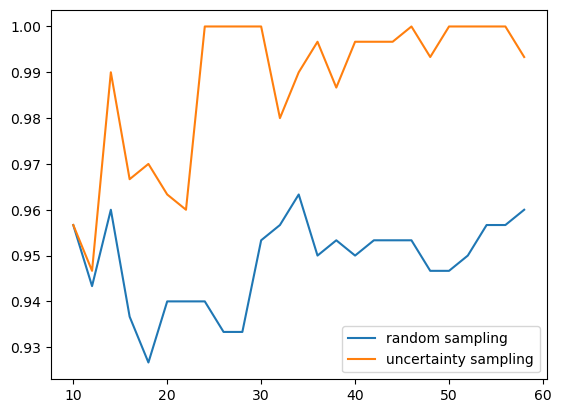

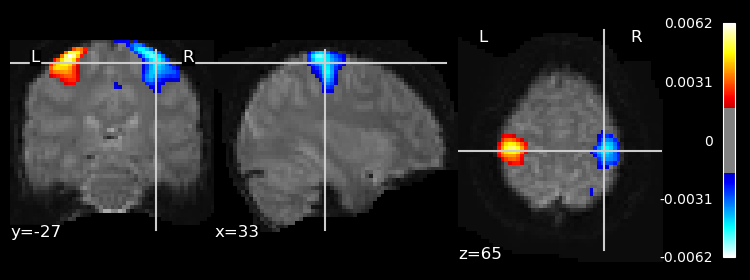

In [10]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_al).T));
plt.legend(('random sampling','uncertainty sampling'));

#if you want to visualize the weightmap of the model you can do like stated below
w=np.zeros(avgimg.shape)
w[mask]=model.coef_[0]
nilearn.plotting.plot_stat_map(nib.Nifti1Image(w,affine=affine),bg_img=nib.Nifti1Image(avgimg,affine=affine),
                               threshold=np.quantile(model.coef_[0],.99));

# Query by commitee
Direct uncertainty sampling is only feasible for models that can provide realistic uncertainty estimates. As an alternative we can consider query by committee (QBC).

In the following train a committee of logistic regression models using bootstrapping (sampling with replacement). For this the function sklearn.util.resample, using stratify=ytrain as an option here will ensure that you don't end up with bootstrap samples with only one label.

The number of member models in the committee is a free parameters which will greatly affect the computational complexity, here something like 10 members should be sufficient. 

<font color=blue> 1. How is the performance compared to uncertainty sampling?<br>
<font color=blue> 2. How sensitive is the performance to the size of the commitee (try a few different sizes)?
<br>Code to write:
<br>Loop in which the current training set is bootstrapped, then the models in the committee are fit and labels for the remaining samples in the pool are estimated. Then refit a model on the entire training set and estimate the accuracy and add it to testacc_qbc. Finally the most uncertain samples (as determined by the disagreement in the committee) are added to the training set and removed from the pool.
   

In [11]:
#reset training set and pool
testacc_qbc=[] #this should hold the final accuracies
ncomm=10
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)
for i in range(25):
    ypool_lab=[]
    # fit models in committee
    for k in range(ncomm):
        #bootstrapping
        Xtr,ytr=sklearn.utils.resample(Xtrain,ytrain,stratify=ytrain)
        #fit
        model.fit(Xtr, ytr)
        #predict
        ypool_lab.append(model.predict(Xpool[poolidx]))
    #get probability of label for each class based on voting in the committee
    ypool_p=(np.mean(np.array(ypool_lab)==1,0),np.mean(np.array(ypool_lab)==2,0))
    ypool_p=np.array(ypool_p).T
    #Refit model in all training data
    model.fit(Xtrain,ytrain)
    ye=model.predict(Xtest)
    testacc_qbc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))
    #select sample with maximum disagreement (least confident)
    ypool_p_sort_idx = np.argsort(-ypool_p.max(1)) #least confident
    #add to training set
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    #remove from pool
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (QBC)'%(ninit+i*addn))


Model: LR, 10 samples (QBC)
Model: LR, 12 samples (QBC)
Model: LR, 14 samples (QBC)
Model: LR, 16 samples (QBC)
Model: LR, 18 samples (QBC)
Model: LR, 20 samples (QBC)
Model: LR, 22 samples (QBC)
Model: LR, 24 samples (QBC)
Model: LR, 26 samples (QBC)
Model: LR, 28 samples (QBC)
Model: LR, 30 samples (QBC)
Model: LR, 32 samples (QBC)
Model: LR, 34 samples (QBC)
Model: LR, 36 samples (QBC)
Model: LR, 38 samples (QBC)
Model: LR, 40 samples (QBC)
Model: LR, 42 samples (QBC)
Model: LR, 44 samples (QBC)
Model: LR, 46 samples (QBC)
Model: LR, 48 samples (QBC)
Model: LR, 50 samples (QBC)
Model: LR, 52 samples (QBC)
Model: LR, 54 samples (QBC)
Model: LR, 56 samples (QBC)
Model: LR, 58 samples (QBC)


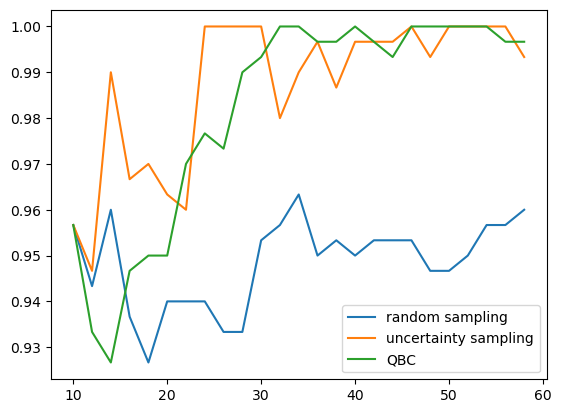

In [12]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_al).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.legend(('random sampling','uncertainty sampling','QBC'));

# Expected model change
As a last alternative we will consider expected improvement estimated according to the size of the gradient of the model parameters (hence focus on samples which are expected to change the model the most).

In binary logistic regression the probability of the high class (label=2 in our example) is given by $$p(\boldsymbol{\hat x}|\hat y=2)=\frac{1}{1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})},$$
where $\boldsymbol{\hat x}$ is a new candidate sample from the unlabeled pool. Equivalently for the low class:
$$p(\boldsymbol{\hat x}|\hat y=1)=1-\frac{1}{1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})}=\frac{\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})}{1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})}.$$

Hence, the loss function then becomes:
$$\mathcal L(\boldsymbol{\hat x}|\hat y=2)=-\operatorname{log}(p(\boldsymbol{\hat x}|\hat y=2))=\operatorname{log}(1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})),$$ and
$$\mathcal L(\boldsymbol{\hat x}|\hat y=1)=-\operatorname{log}(p(\boldsymbol{\hat x}|\hat y=2))=\operatorname{log}(1+\operatorname{exp}(\boldsymbol\theta^\top \boldsymbol{\hat{x}})).$$


We now differentiate with respect to the parameters for each of these cases to obtain (you could of course also do this with automatic differentiation in pytorch, but for sake of example we do it analytically here, there are few basic manipulations of exponentials needed here to get this compact notation (note that the minus in $\operatorname{exp}(-\theta_i x_i)$ disappeared):
$$\frac{\delta \mathcal L(\boldsymbol{\hat x}|\hat y=2)}{\delta \theta_i}=\frac{- {\hat x_i}}{1+\operatorname{exp}(\theta_i {\hat{x_i}})},$$ and 
$$\frac{\delta \mathcal L(\boldsymbol{\hat x}|\hat y=1)}{\delta \theta_i}=\frac{{\hat x_i} \operatorname{exp}(\theta {\hat{x_i}})}{1+\operatorname{exp}(\theta_i {\hat{x_i}})}.$$

As we actually use the l2 penalized logistic regression here the complete cost function actually contains an additional shrinkage term $1/(2C) ||\theta||^2$. The complete derivatives are actually as follows:

$$\frac{\delta \mathcal{\tilde{L}}(\boldsymbol{\hat x}|\hat y=2)}{\delta \theta_i}=\frac{- {\hat x_i}}{1+\operatorname{exp}(\theta_i {\hat{x_i}})}+\theta_i/C,$$ and 
$$\frac{\delta \mathcal{\tilde{L}}(\boldsymbol{\hat x}|\hat y=1)}{\delta \theta_i}=\frac{{\hat x_i} \operatorname{exp}(\theta {\hat{x_i}})}{1+\operatorname{exp}(\theta_i {\hat{x_i}})}+\theta_i/C.$$


From this calculate the euclidean norm of the gradient and weight according to $p(\boldsymbol{\hat x})$. In accordance with the description in the notes the gradient of the points within the training set are close to zero as the model has converged to samples the training set, therefore we only need to evaluate this for each candidate point individually.

In our model is severely overparametrized as there are many features (voxels) out of which most are actually not relevant for classification. Therefore, this metric might not work well as the gradient will likely be dominated by unimportant voxels.
In such cases regularization can be important as well as preprocessing measures to ensure that features are appropriately normalized, which we did not consider in this exercise.

<font color=blue>Now use this expected improvement metric to suggest new samples from the pool,
and visualize the training curve.
<font color=blue>Use this expected improvement metric to suggest new samples from the pool,
and visualize the training curve.
<br>Code to write:
<br>Function to calculate the length of the gradient (parameters $\theta$ are in model.coef_ after model is fitted), then complete training loop by fit current model, determine accuracy (add to testacc_emc) then invoke gradient length function on remaining pool, add candidate sample to training set and remove from the pool.


In [13]:
#reset training set and pool
testacc_emc=[]
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

def norm_grad_x(theta,x,C=1.):
    #probability of high class
  p1 = 1/(1+np.exp(-np.sum(theta*x)))
    #probability of low class
  p0 = 1-p1
    #derivative of cost as derived above for high class
  dL1=-x/(1+np.exp(theta*x))+theta/C
    #same for low class
  dL0=x*np.exp(theta*x)/(1+np.exp(theta*x))+theta/C
    #2-norm of these
  g1=np.sqrt(np.sum(dL1**2,1))
  g0=np.sqrt(np.sum(dL0**2,1))
    #averaged according to probabilities
  emc=p1*g1+p0*g0
  return emc

In [14]:
for i in range(25):
    model.fit(Xtrain,ytrain)
    emc=norm_grad_x(model.coef_, Xpool[poolidx])
    ye=model.predict(Xtest)
    testacc_emc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))


    ypool_p_sort_idx = np.argsort(emc)
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (EMC)'%(ninit+i*addn))


Model: LR, 10 samples (EMC)
Model: LR, 12 samples (EMC)
Model: LR, 14 samples (EMC)
Model: LR, 16 samples (EMC)
Model: LR, 18 samples (EMC)
Model: LR, 20 samples (EMC)
Model: LR, 22 samples (EMC)
Model: LR, 24 samples (EMC)
Model: LR, 26 samples (EMC)
Model: LR, 28 samples (EMC)
Model: LR, 30 samples (EMC)
Model: LR, 32 samples (EMC)
Model: LR, 34 samples (EMC)
Model: LR, 36 samples (EMC)
Model: LR, 38 samples (EMC)
Model: LR, 40 samples (EMC)
Model: LR, 42 samples (EMC)
Model: LR, 44 samples (EMC)
Model: LR, 46 samples (EMC)
Model: LR, 48 samples (EMC)
Model: LR, 50 samples (EMC)
Model: LR, 52 samples (EMC)
Model: LR, 54 samples (EMC)
Model: LR, 56 samples (EMC)
Model: LR, 58 samples (EMC)


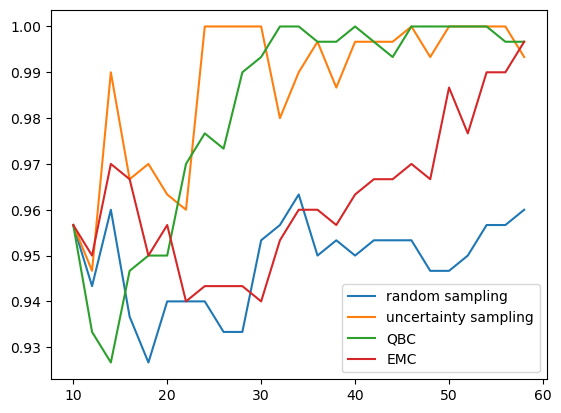

In [15]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_al).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.plot(*tuple(np.array(testacc_emc).T));
plt.legend(('random sampling','uncertainty sampling','QBC','EMC'));


<span style="color:green;font-style:italic">
    Here we see that the expected model change/impact is not doing as well here as already hinted above this is likely because the number of model parameters (weights) is very high and therefore the gradient will likely be dominated by unimportant voxels even if they have low weigth in the model.  
    </span>